In [1]:
from bucket_model import BucketModel
from bucket_model_optimizer import BucketModelOptimizer
from data_preprocessor import preprocess_data

from bucket_model_plotter import plot_water_balance, plot_Q_Q, plot_ECDF, plot_KDE, plot_monthly_boxplot, plot_timeseries

import pandas as pd

In [2]:
path_to_file = '/Users/cooper/Desktop/BucketModel/data/GSTEIGmeteo.txt'
output_destination = '/Users/cooper/Desktop/BucketModel/data/GSTEIGmeteo.csv'
catchment_area = 384.2 # km^2
training_data = preprocess_data(path_to_file=path_to_file, catchment_area=catchment_area)

# training_data = pd.read_csv(output_destination, index_col=0)
# training_data.index = pd.to_datetime(training_data.index)

training_data

,P_mix,T_max,T_min,Q
date,,,,
1986-01-01,2.5,-2.5,-11.6,0.512733
1986-01-02,0.2,2.6,-10.7,0.537470
1986-01-03,4.3,2.2,-5.3,0.532972
1986-01-04,3.4,-4.0,-12.9,0.526226
1986-01-05,3.6,1.9,-13.3,0.526226
...,...,...,...,...
2000-09-26,0.0,16.3,5.8,3.215825
2000-09-27,0.0,15.6,5.3,3.238313
2000-09-28,0.0,14.1,6.0,3.238313


In [3]:
# Initialize the BucketModel with initial parameter guesses
bucket = BucketModel(0.5, 20, 0.14, 15.15)  # k, S_max, fr, rg, 
bucket.set_catchment_properties(0.5/100, 1638, 2035, 0, 46.9)

# Initialize the BucketModelOptimizer with the BucketModel instance and observed data
optimizer = BucketModelOptimizer(model=bucket, training_data=training_data)

# Optionally, set additional optimization options, like optimization method, parameter bounds, etc.
optimizer.set_options(method='local', bounds={'k': (0.1, 1), 'S_max': (10, 50), 'fr': (0.1, 0.3), 'rg': (10, 20)})

In [4]:
# # Run the optimization to calibrate the model parameters
# optimized_parameters = optimizer.optimize()

In [5]:
# optimized_parameters

In [6]:
# bucket.update_parameters(optimized_parameters)
# bucket

In [7]:
results = bucket.run(training_data)

In [8]:
results

,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip
date,,,,,,,,,,
1986-01-01,0.086282,0.00000,6.600660,2.500000,9.913718,93.399340,0.0000,0.000000,2.500000,2.5
1986-01-02,0.107127,0.00000,6.164973,2.690752,9.815840,87.234367,0.0000,0.009248,0.190752,0.2
1986-01-03,0.127491,0.00000,5.758044,6.867485,9.811616,81.476323,0.0000,0.123267,4.176733,4.3
1986-01-04,0.077042,0.00000,5.377975,10.267485,9.734574,76.098348,0.0000,0.000000,3.400000,3.4
1986-01-05,0.094323,0.00000,5.022993,13.867485,9.640250,71.075355,0.0000,0.000000,3.600000,3.6
...,...,...,...,...,...,...,...,...,...,...
2000-09-26,1.166338,0.63455,5.728374,40.547040,20.000000,83.788099,4.5325,0.000000,0.000000,0.0
2000-09-27,1.111294,0.59255,5.530568,36.314540,20.000000,80.786187,4.2325,0.000000,0.000000,0.0
2000-09-28,1.072360,0.56455,5.332422,32.282040,20.000000,77.849355,4.0325,0.000000,0.000000,0.0


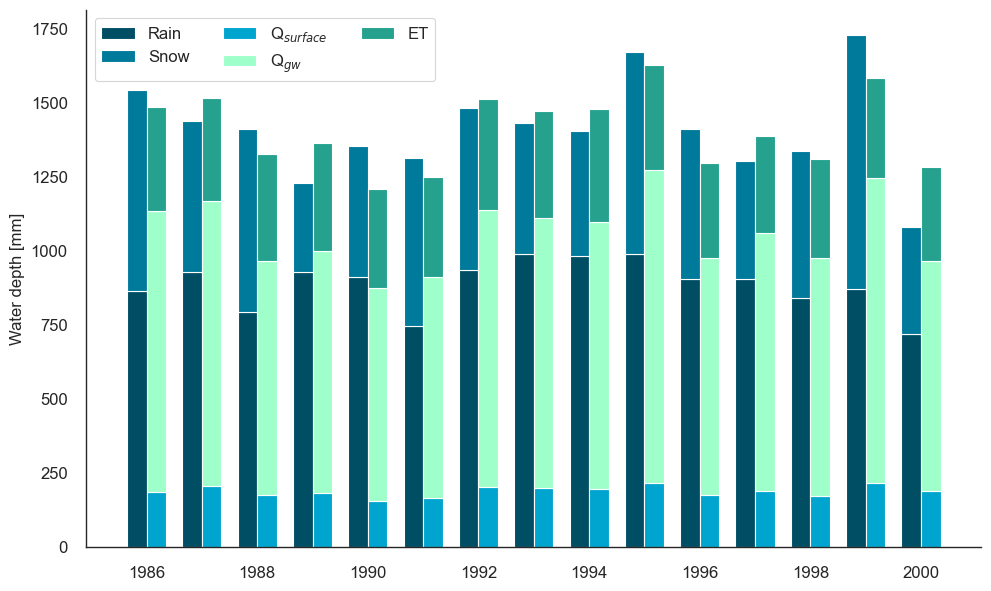

In [9]:
plot_water_balance(results)


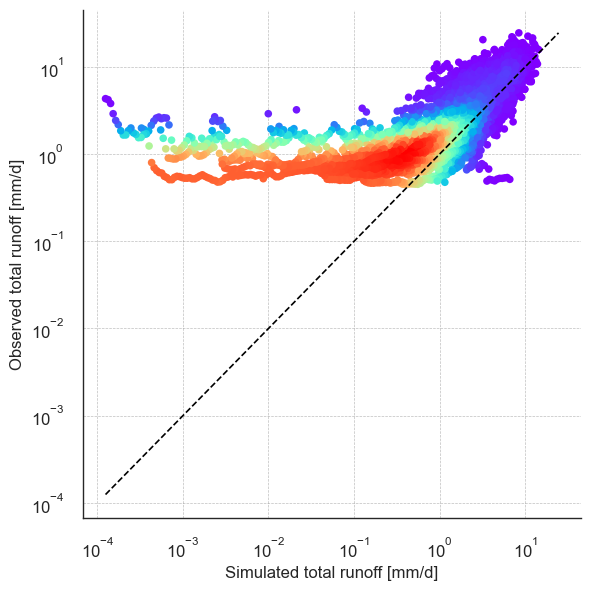

In [10]:
plot_Q_Q(results=results, validation=training_data, kde=True)

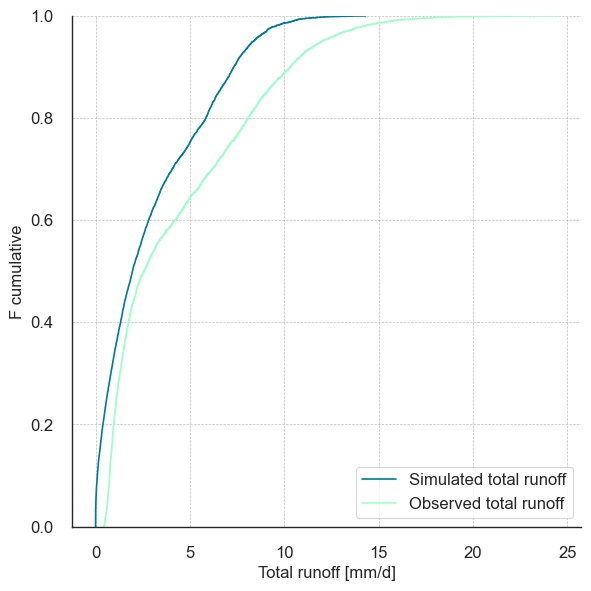

In [11]:
plot_ECDF(results=results, validation=training_data)

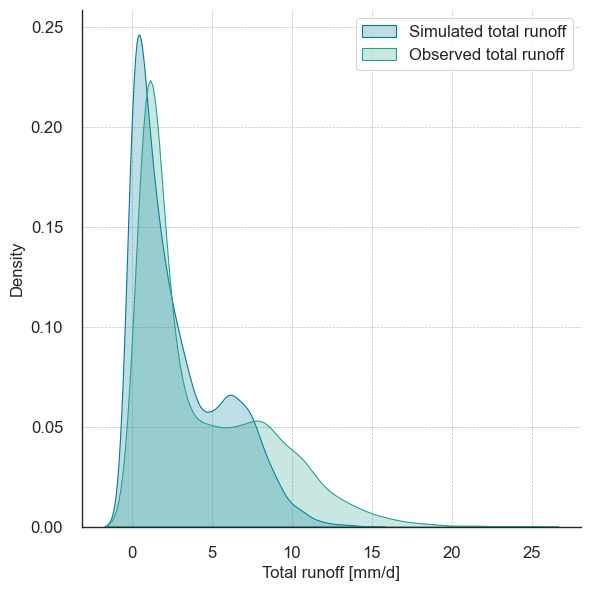

In [12]:
plot_KDE(results=results, validation=training_data)

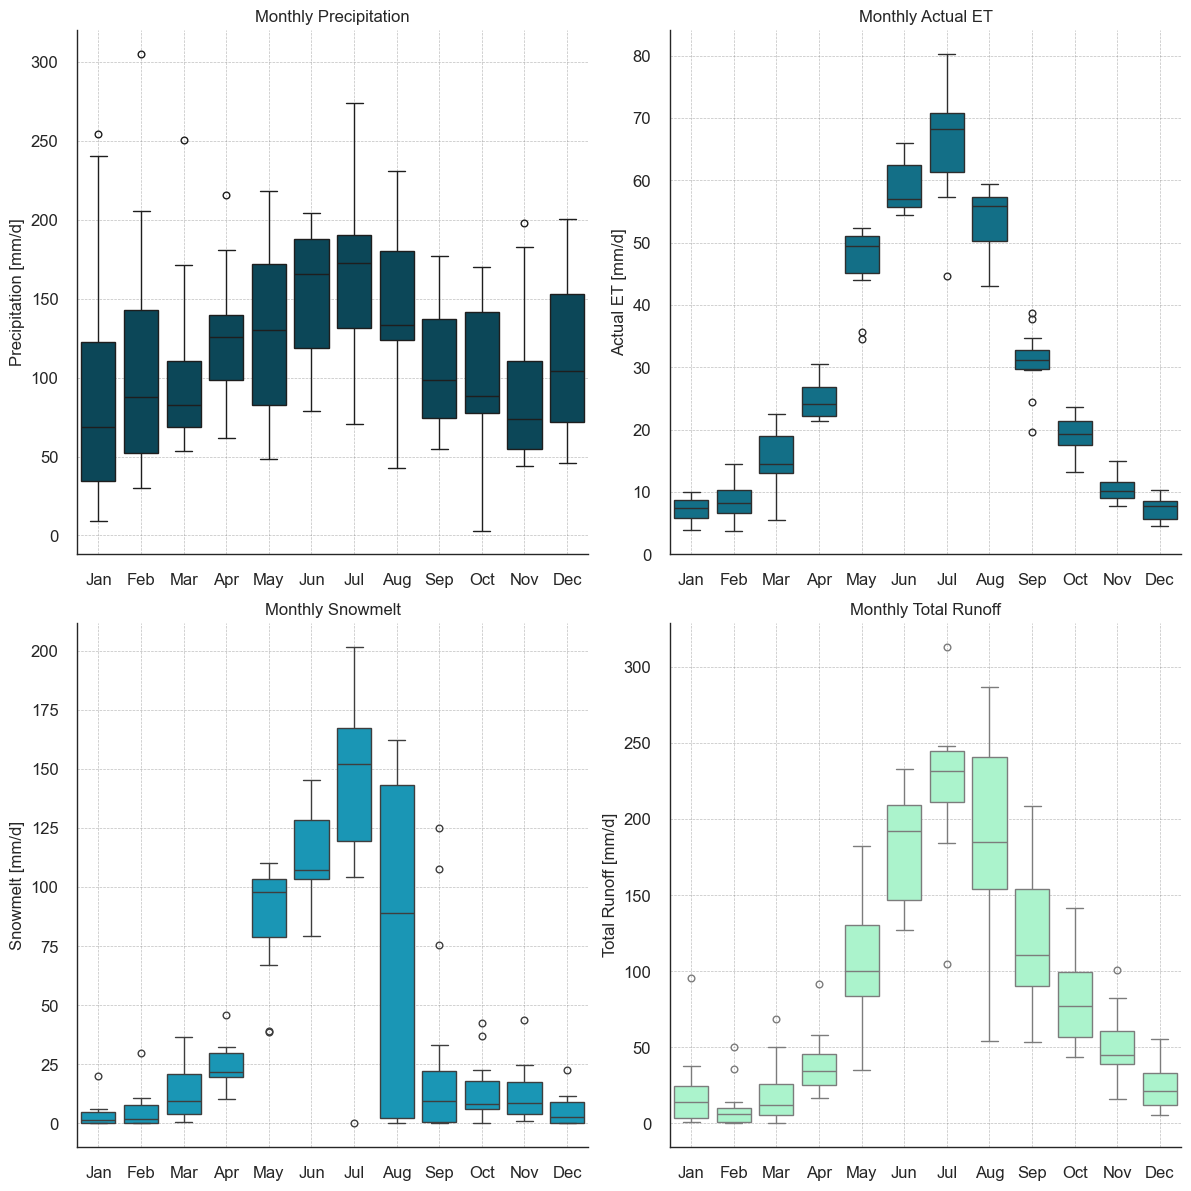

In [13]:
plot_monthly_boxplot(results=results)

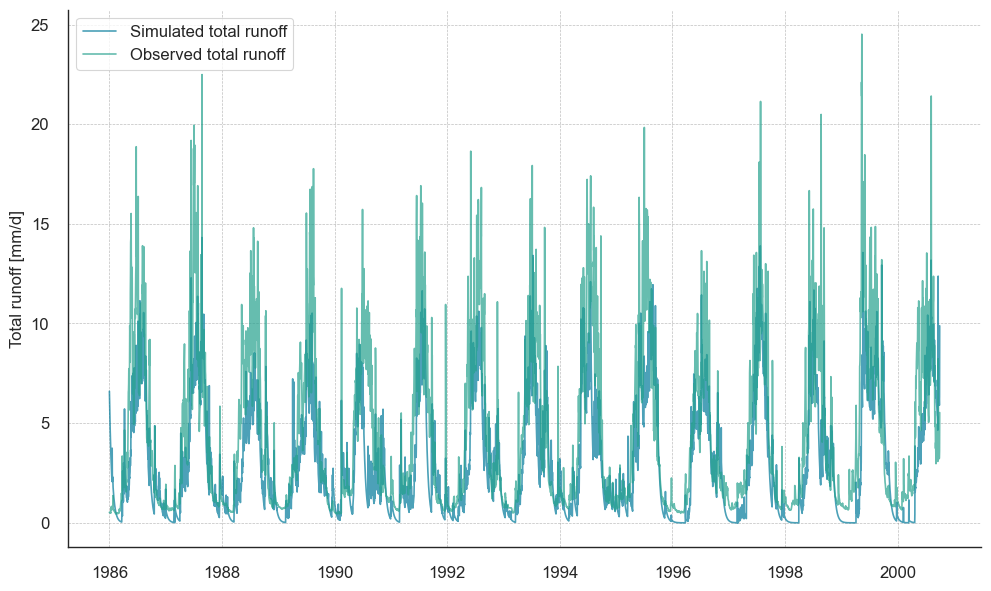

In [14]:
plot_timeseries(results=results, validation=training_data, start_year='1986', end_year='1993')

/Users/cooper/Desktop/BucketModel/bucket_model_plotter.py:341: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  results_filtered = results_filtered[start_year:end_year].resample('M').sum()
/Users/cooper/Desktop/BucketModel/bucket_model_plotter.py:342: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  validation = validation[start_year:end_year].resample('M').sum()


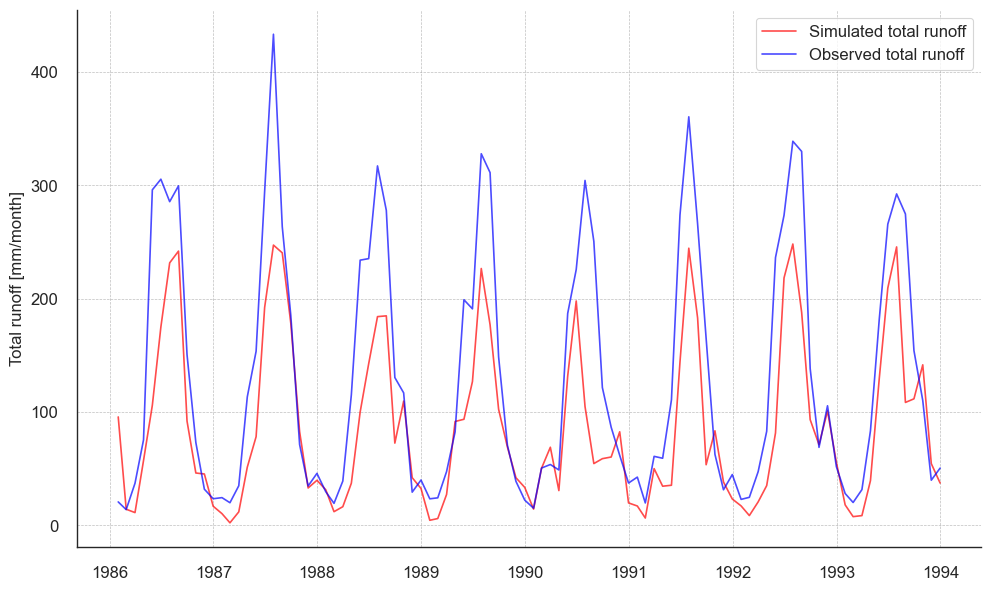

In [16]:
plot_timeseries(results=results, validation=training_data, start_year='1986', end_year='1993', monthly=True, palette=['red', 'blue'])